## Gesture Recognition

In [1]:
import numpy as np
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


### Generator

In [5]:
class Generator():
        
    def properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def hyperparams(self,frames_to_sample=30,batch_size=5,num_epochs=15):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs   
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.run_batch(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.run_batch(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    def run_batch(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                image_resized=cv2.resize(image,(self.image_height,self.image_width))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    # Gray Scale
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)
                    
                    # Cropping
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    # Resizing
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    # Rotation
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    image_rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    # Normalization
                    batch_data_aug[folder,idx,:,:,0] = (image_rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_rotated[:,:,2])/255
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)

### Model Building

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [7]:
def train_model():
    model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    return history

#### Conv3D

In [8]:
model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(30,100,100,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

optimiser = optimizers.Adam(lr=0.01)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 50, 50, 32)    128       
__________

Epoch 1/20
34/34 [==============================] - 209s 6s/step - loss: 1.6801 - categorical_accuracy: 0.3915 - val_loss: 9.9107 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2020-12-2605_33_34.159065/model-00001-1.66388-0.39291-9.91073-0.24000.h5
Epoch 2/20
34/34 [==============================] - 103s 3s/step - loss: 1.1847 - categorical_accuracy: 0.5210 - val_loss: 10.7962 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-12-2605_33_34.159065/model-00002-1.17431-0.52564-10.79620-0.23000.h5
Epoch 3/20
34/34 [==============================] - 104s 3s/step - loss: 1.0898 - categorical_accuracy: 0.5419 - val_loss: 2.7900 - val_categorical_accuracy: 0.2750

Epoch 00003: saving model to model_init_2020-12-2605_33_34.159065/model-00003-1.09608-0.54299-2.78997-0.27500.h5
Epoch 4/20
34/34 [==============================] - 106s 3s/step - loss: 0.9312 - categorical_accuracy: 0.6118 - val_loss: 0.9670 - val_categorical_accuracy: 0.6

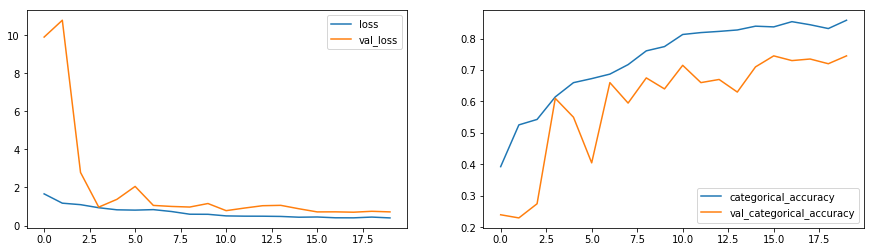

In [9]:
batch_size=20
obj1 = Generator()
obj1.properties(image_height=100,image_width=100)
obj1.hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
train_generator = obj1.generator(train_path, train_doc,batch_size)
val_generator = obj1.generator(val_path, val_doc, batch_size)
model_Conv3D = train_model()

Not overfitting but also not a very good accuracy

Both categorical and validation accuracy are increasing steadily

#### Conv2D + GRU

In [10]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(30,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))
optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 25, 25, 64)    18496     
__________

Epoch 1/20
34/34 [==============================] - 100s 3s/step - loss: 1.4614 - categorical_accuracy: 0.3926 - val_loss: 1.1855 - val_categorical_accuracy: 0.5450

Epoch 00001: saving model to model_init_2020-12-2606_08_08.066691/model-00001-1.46724-0.38989-1.18548-0.54500.h5
Epoch 2/20
34/34 [==============================] - 92s 3s/step - loss: 1.1000 - categorical_accuracy: 0.5511 - val_loss: 1.0749 - val_categorical_accuracy: 0.5550

Epoch 00002: saving model to model_init_2020-12-2606_08_08.066691/model-00002-1.08887-0.56486-1.07491-0.55500.h5
Epoch 3/20
34/34 [==============================] - 93s 3s/step - loss: 0.9232 - categorical_accuracy: 0.6475 - val_loss: 0.8777 - val_categorical_accuracy: 0.6750

Epoch 00003: saving model to model_init_2020-12-2606_08_08.066691/model-00003-0.90731-0.65535-0.87773-0.67500.h5
Epoch 4/20
34/34 [==============================] - 94s 3s/step - loss: 0.7593 - categorical_accuracy: 0.7123 - val_loss: 0.8507 - val_categorical_accuracy: 0.6600



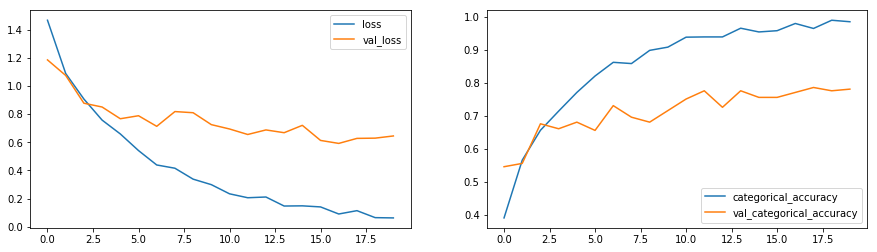

In [11]:
batch_size=20
obj2 = Generator()
obj2.properties(image_height=100,image_width=100)
obj2.hyperparams(frames_to_sample=30,batch_size=20,num_epochs=20)
train_generator = obj2.generator(train_path, train_doc,batch_size)
val_generator = obj2.generator(val_path, val_doc, batch_size)
model_Conv2D = train_model()

Validation accuracy is not as great as the categorical accuracy

### Final Model

#### Conv2D + GRU with transfer learning

In [12]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(30,100,100,3)))
 
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                209088    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (De

Epoch 1/20
67/67 [==============================] - 127s 2s/step - loss: 1.1328 - categorical_accuracy: 0.5328 - val_loss: 0.6804 - val_categorical_accuracy: 0.7650

Epoch 00001: saving model to model_init_2020-12-2606_39_41.314424/model-00001-1.12625-0.53318-0.68043-0.76500.h5
Epoch 2/20
67/67 [==============================] - 109s 2s/step - loss: 0.6037 - categorical_accuracy: 0.7605 - val_loss: 0.4970 - val_categorical_accuracy: 0.8050

Epoch 00002: saving model to model_init_2020-12-2606_39_41.314424/model-00002-0.59830-0.76320-0.49695-0.80500.h5
Epoch 3/20
67/67 [==============================] - 109s 2s/step - loss: 0.5209 - categorical_accuracy: 0.8083 - val_loss: 0.3852 - val_categorical_accuracy: 0.8500

Epoch 00003: saving model to model_init_2020-12-2606_39_41.314424/model-00003-0.51636-0.81146-0.38516-0.85000.h5
Epoch 4/20
67/67 [==============================] - 109s 2s/step - loss: 0.3920 - categorical_accuracy: 0.8663 - val_loss: 0.3190 - val_categorical_accuracy: 0.890

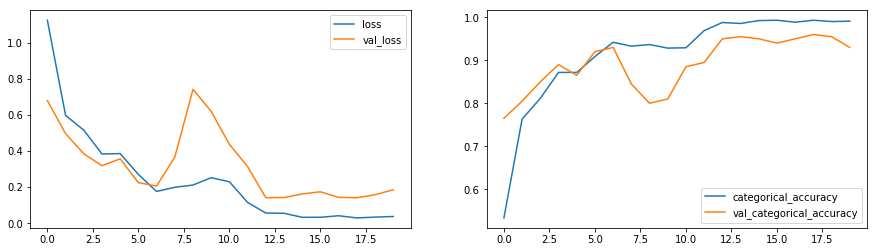

In [13]:
batch_size=10
obj3 = Generator()
obj3.properties(image_height=100,image_width=100)
obj3.hyperparams(frames_to_sample=30,batch_size=10,num_epochs=20)
train_generator = obj3.generator(train_path, train_doc,batch_size)
val_generator = obj3.generator(val_path, val_doc, batch_size)
final_model = train_model()

Excellent validation accuracy and better than the Conv3D and Conv2D+GRU models